# Emulator and figures

In [1]:
# %load first_cell.py
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=67.26, Om0=0.314, Ob0=0.049)

from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"


def print_shape(*args):
    nelem = len(args)
    for ii in range(nelem - 1):
        print(args[ii].shape, end=" ")
    print(args[nelem - 1].shape)


def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder


path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

/home/jchaves/Proyectos/projects/lya/lya_pk/


In [2]:
from lya_pk.archive import GadgetArchive3D
from lya_pk.emulator_p3d import P3DEmulator

## Load training data

In [3]:
%%time
folder_lya_data = path_program + "data/best_arinyo/"

Archive3D = GadgetArchive3D(folder_data=folder_lya_data)
print(len(Archive3D.training_data))

1650
CPU times: user 11.1 s, sys: 181 ms, total: 11.3 s
Wall time: 11.3 s


In [4]:
# p3d_paramnames = [
#     "bias",
#     "beta",
#     "d1_q1",
#     "d1_kvav",
#     "d1_av",
#     "d1_bv",
#     "d1_kp",
#     "d1_q2",
# ]

## Train or load emulator

In [5]:
p3d_emu = P3DEmulator(Archive3D.training_data, Archive3D.emu_params, nepochs=1)

start the training of the emulator
Emualtor trained in 0.12717914581298828 seconds


torch.save(p3d_emu.emulator.state_dict(),'p3demu_vo.pt')

In [5]:
p3d_emu = P3DEmulator(
    Archive3D.training_data,
    Archive3D.emu_params,
    nepochs=300,
    model_path="p3demu_vo.pt",
    train=False,
)

Model loaded. No training needed


## Load testing data

In [6]:
sim_label = "mpg_central"
testing_data = Archive3D.get_testing_data(sim_label)

In [7]:
# from lya_pk.likelihood import Likelihood

In [8]:
# smooth = like.like.get_model_3d(parameters=testing_data[ind_book]["Arinyo"])
# pred = like.like.get_model_3d(parameters=)

In [32]:
nbook = len(Archive3D.training_data)
nparams = len(Archive3D.emu_params)
priors_params = np.zeros((nparams, 2))
central_params = np.zeros((nparams))


for ii in range(nbook):
    for jj, par in enumerate(Archive3D.emu_params):
        val = Archive3D.training_data[ii][par]

        if ii == 0:
            priors_params[jj, :] = val
            central_params[jj] = testing_data[6][par]
        else:
            if val > priors_params[jj, 1]:
                priors_params[jj, 1] = val
            if val < priors_params[jj, 0]:
                priors_params[jj, 0] = val

# by hand from Laura
priors_params[0, :] = [0.29, 0.45]
# priors_params[1, :] = [-2.34, -2.2]
priors_params[2, :] = [0.6, 0.7]
priors_params[3, :] = [0.11, 0.15]
priors_params[4, :] = [1.29, 1.73]
priors_params[5, :] = [9.85, 11.88]

neval = 50
eval_params = np.zeros((nparams, neval))
for jj, par in enumerate(Archive3D.emu_params):
    eval_params[jj] = np.linspace(
        priors_params[jj, 0], priors_params[jj, 1], neval
    )
    print(par, priors_params[jj])

Delta2_p [0.29 0.45]
n_p [-2.34838752 -2.25172027]
mF [0.6 0.7]
sigT_Mpc [0.11 0.15]
gamma [1.29 1.73]
kF_Mpc [ 9.85 11.88]


In [10]:
central_params

array([ 0.35003151, -2.30005452,  0.66041007,  0.12817464,  1.51217092,
       10.63483818])

In [33]:
pred_params = np.zeros((nparams, neval, 2))
for ii in range(nparams):
    use_params = central_params.copy()
    for jj in range(neval):
        use_params[ii] = eval_params[ii, jj]

        _pars = p3d_emu.get_coeff(use_params)
        pred_params[ii, jj, 0] = _pars[0]
        pred_params[ii, jj, 1] = _pars[0] * (1 + _pars[1])

## Plot for Andreu

<IPython.core.display.Javascript object>


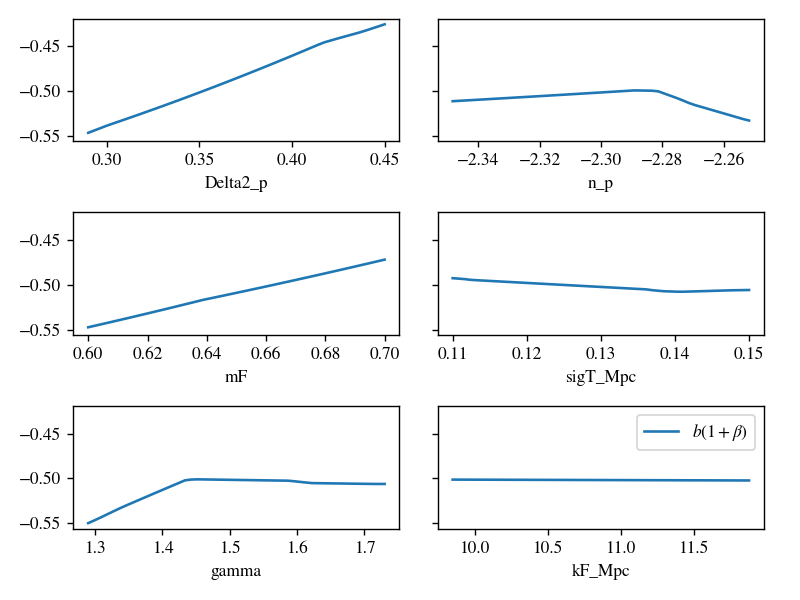

In [37]:
fig, ax = plt.subplots(3, 2, sharey=True)
ax = ax.reshape(-1)
for ii in range(nparams):
    #     ax[ii].plot(eval_params[ii], pred_params[ii, :, 0], label=r"$b$")
    ax[ii].plot(eval_params[ii], pred_params[ii, :, 1], label=r"$b(1+\beta)$")
    ax[ii].set_xlabel(Archive3D.emu_params[ii])

# plt.plot(eval_params[ii], pred_params[ii, :, 1])

plt.tight_layout()
plt.legend()
plt.savefig("params_cosmo_1.png")

In [76]:
fit_pars = testing_data[ind_book]["Arinyo"]

In [ ]:
p3d_emu.get_coeff(testing_data)

<IPython.core.display.Javascript object>


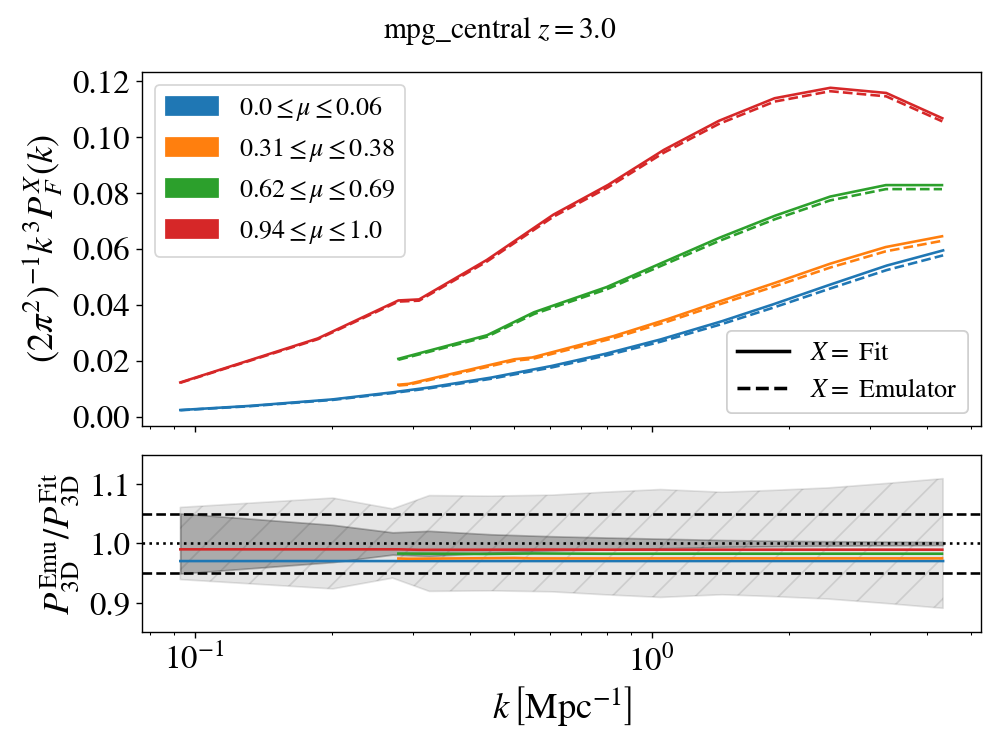

In [43]:
ind_book = 6

like = Likelihood(
    testing_data[ind_book], Archive3D.rel_err_p3d, Archive3D.rel_err_p1d
)

fit_pars = testing_data[ind_book]["Arinyo"]
emu_pars = params_numpy2dict(pred_arinyo[ind_book])

# save_fig = "test.png"
save_fig = None
plot_compare_p3d_smooth(
    like.like,
    fit_pars,
    emu_pars,
    sim_label="mpg_central",
    err_bar_all=True,
    save_fig=save_fig,
)

In [16]:
ind_book = 0
emu_pars = params_numpy2dict(emu_arinyo[ind_book])
# fit_pars = archive.testing_data[ind_book]['Arinyo']

NameError: name 'emu_arinyo' is not defined

In [ ]:

plot_compare_p3d_smooth(testing_data[ind_book]['model'], fit_pars, 
                        emu_pars, sim_label=sim_label, err_bar_all=True)

In [49]:
folder = path_program + "data/"
folder_chains = (
    "/home/jchaves/Proyectos/projects/lya/data/pkfits/p3d_fits_new/"
)
folder_interp = path_program + "data/plin_interp/"
err_pnd = np.load(folder + "std_pnd_mpg.npz")
err_p1d = err_pnd["std_p1d"]
err_p3d = err_pnd["std_p3d"]

In [51]:
err_p1d.shape

(676,)

In [15]:
from lya_pk.input_emu import data_for_emu_v1

In [17]:
%%time
data_emu = data_for_emu_v1(
    folder_chains,
    folder_interp,
    testing_data,
    err_p3d,
    err_p1d,
    Archive3D.kmax_3d,
    Archive3D.noise_3d,
    Archive3D.kmax_1d,
    Archive3D.noise_1d,
)

CPU times: user 6.34 ms, sys: 749 µs, total: 7.08 ms
Wall time: 21.2 ms


In [19]:
data_emu.keys()

dict_keys(['in_params', 'out_params', 'model', 'emu_params_names'])

In [28]:
data_emu["emu_params_names"]

array(['Delta2_p', 'n_p', 'mF', 'sigT_Mpc', 'gamma', 'kF_Mpc'],
      dtype='<U8')

In [34]:
data_emu["model"][0].data.keys()

dict_keys(['units', 'z', 'k3d', 'mu3d', 'p3d', 'std_p3d', 'k1d', 'p1d', 'std_p1d', 'emu_params_names', 'emu_params', 'std_p3d_sta', 'std_p3d_sys', 'std_p1d_sta', 'std_p1d_sys'])

In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

import time

from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=67.26, Om0=0.314, Ob0=0.049)

from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"

import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

from lya_pk.input_emu import get_flag_out, add_Arinyo_to_archive
from lya_pk.input_emu import data_for_emu_v1, params_numpy2dict

from lace.archive.gadget_archive import GadgetArchive
from lace.archive.nyx_archive import NyxArchive

In [2]:
def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder


path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

/home/jchaves/Proyectos/projects/lya/lya_pk/


In [3]:

import os
env_var = os.environ
# os.environ["LACE_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE"
# os.environ["LACE_MANAGER_REPO"] = "/nfs/pic.es/user/l/lcabayol/DESI/LaCE_manager"
os.environ["LACE_REPO"] = ls_level(os.getcwd(), 2) + 'LaCE'
os.environ["LACE_MANAGER_REPO"] = ls_level(os.getcwd(), 2) + 'LaCE_manager'

# DEFINE TRAINING ARCHIVE AND TRAIN P3D EMULATOR

## DEFINE ARCHIVE.

- Load an archive
- Average over phases and axes
- Add Arinyo parameters to archive
- Rename data_av_all to training_data for consistency

In [5]:


# testing_data = []
# for sim in archive.list_sim_test:
#     for ii in range(5):
#         testing_data += archive.get_testing_data(sim, ind_rescaling=ii)
# archive.testing_data = testing_data
# len(testing_data)

1650


In [8]:
folder = path_program + "data/"
# folder_chains = "/data/desi/scratch/jchavesm/p3d_fits_new/"
folder_chains = "/home/jchaves/Proyectos/projects/lya/data/pkfits/p3d_fits_new/"
folder_plin_nou = path_program + "data/Plin_no_dim/"

sim_suite = 'hypercube'

kmax_3d = 5
noise_3d = 0.075
kmax_1d = 5
noise_1d = 0.01
folder_interp = path_program + "data/plin_interp/"
folder_lya_data = path_program + "data/best_arinyo/"



NameError: name 'data_for_emu_v1' is not defined

In [ ]:
%%time
data_emu = data_for_emu_v1(
    folder_chains,
    folder_interp,
    ,
    err_p3d,
    err_p1d,
    kmax_3d,
    noise_3d,
    kmax_1d,
    noise_1d,
)

## TRAIN P3D EMULATOR

In [10]:
emu_params = ['Delta2_p', 'n_p','mF', 'gamma', 'sigT_Mpc', 'kF_Mpc']
p3d_paramnames =['bias', 'beta', 'd1_q1','d1_kvav','d1_av', 'd1_bv', 'd1_kp' ,'d1_q2']

In [46]:
emu_params = ['Delta2_p', 'n_p','mF', 'gamma', 'sigT_Mpc', 'kF_Mpc']
p3d_paramnames =['bias', 'beta', 'd1_q1','d1_kvav','d1_av', 'd1_bv', 'd1_kp' ,'d1_q2']
p3d_emu = P3DEmulator(archive, emu_params, nepochs=1)

start the training of the emulator
Emualtor trained in 0.06482887268066406 seconds


torch.save(p3d_emu.emulator.state_dict(),'p3demu_vo.pt')

## LOAD TRAINED EMULATOR

In [11]:
p3d_emu = P3DEmulator(archive,emu_params,nepochs=300,model_path='p3demu_vo.pt', train=False)

Model loaded. No training needed


## DEFINE TEST ARCHIVE

In [13]:
archive.testing_data[0].keys()

dict_keys(['ind_axis', 'ind_phase', 'sim_label', 'ind_rescaling', 'ind_snap', 'Delta2_p', 'n_p', 'alpha_p', 'f_p', 'z', 'mF', 'p3d_Mpc', 'k3d_Mpc', 'mu3d', 'T0', 'gamma', 'sigT_Mpc', 'kF_Mpc', 'k_Mpc', 'p1d_Mpc', 'val_scaling', 'Arinyo', 'Arinyo_25', 'Arinyo_75'])

In [16]:
print(archive.testing_data[0]['Arinyo'])
print(archive.testing_data[0]['Arinyo_25'])
print(archive.testing_data[0]['Arinyo_75'])

{'bias': -0.7032259180413809, 'beta': 0.312767881322462, 'd1_q1': 1.1979051855926777, 'd1_kvav': 2.0643277950653918, 'd1_av': 0.678395452923365, 'd1_bv': 1.999148800096719, 'd1_kp': 16.556507932064346, 'd1_q2': 0.5777619673587411}
{'bias': -0.751579325419506, 'beta': 0.26643000148935025, 'd1_q1': 0.4106211942362144, 'd1_kvav': 0.8972315542723062, 'd1_av': 0.34582473080848397, 'd1_bv': 1.447230385442453, 'd1_kp': 14.618153735852893, 'd1_q2': 0.37335317747564356}
{'bias': -0.6301252274678527, 'beta': 0.6328326852136998, 'd1_q1': 1.5221657941451805, 'd1_kvav': 1.9003267142941969, 'd1_av': 0.8283305776729425, 'd1_bv': 2.7091348714643932, 'd1_kp': 25.6257319987156, 'd1_q2': 1.4338565726246566}


In [28]:

from lya_pk.plot_routines import plot_template

In [17]:
emu_arinyo, emu_p3d = p3d_emu._get_p3D_Mpc(archive, data_emu)

In [59]:
# ind_book = 10

# # outside of class?
# data_emu["model"][ind_book].plot_compare_smooth(emu_pars, fit_pars)

In [94]:
data_emu["model"][ind_book].data.keys()

dict_keys(['units', 'z', 'k3d', 'mu3d', 'p3d', 'std_p3d', 'k1d', 'p1d', 'std_p1d', 'emu_params_names', 'emu_params', 'std_p3d_sta', 'std_p3d_sys', 'std_p1d_sta', 'std_p1d_sys'])

In [144]:
ind_book = 6
emu_pars = params_numpy2dict(emu_arinyo[ind_book])
fit_pars = archive.testing_data[ind_book]['Arinyo']

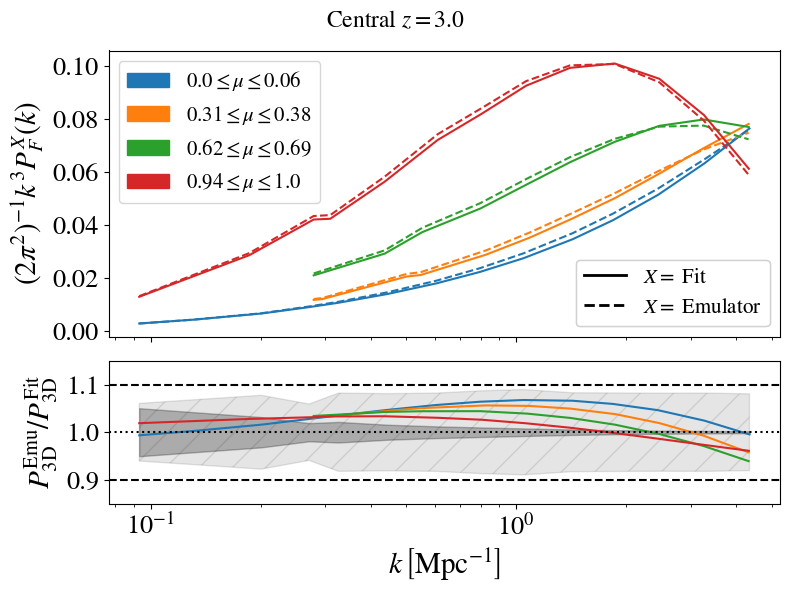

In [149]:
save_fig = 'Durham_p3d.png'
plot_compare_p3d_smooth(data_emu["model"][ind_book], fit_pars, 
                        emu_pars, sim_label=sim_label, err_bar_all=True,save_fig=save_fig)

In [ ]:
noise_3d = 0.075

In [130]:
data_emu["model"][ind_book].data['p3d'][:,0]

array([0.00215739, 0.0042078 , 0.00664071, 0.00697871, 0.01148636,
       0.01491467, 0.0195146 , 0.0255681 , 0.03256165, 0.03803059,
       0.04578094, 0.0559106 , 0.0690938 , 0.0819389 , 0.09485516,
       0.10492326, 0.10739816, 0.09815862, 0.08062325, 0.07354857])

In [ ]:
data_emu["model"][ind_book].get_model_3d(parameters=fit_pars)

In [128]:
data_emu["model"][ind_book].units

'N'

In [60]:
data_emu["model"][ind_book].data.keys()

dict_keys(['units', 'z', 'k3d', 'mu3d', 'p3d', 'std_p3d', 'k1d', 'p1d', 'std_p1d', 'emu_params_names', 'emu_params', 'std_p3d_sta', 'std_p3d_sys', 'std_p1d_sta', 'std_p1d_sys'])

In [ ]:
# emu_pars = params_numpy2dict(emu_arinyo[ind_book])
fit_pars = archive.testing_data[ind_book]['Arinyo']

In [166]:
pred_bias = emu_arinyo[:,0]
pred_beta = emu_arinyo[:,1]

In [173]:
fit_bias = np.zeros(len(pred_bias))
fit_beta = np.zeros(len(pred_bias))
zz_arr = np.zeros(len(pred_bias))
for ii in range(len(pred_bias)):
    fit_bias[ii] = archive.testing_data[ii]['Arinyo']['bias']
    fit_beta[ii] = archive.testing_data[ii]['Arinyo']['beta']
    zz_arr[ii] = archive.testing_data[ii]['z']

In [151]:

import matplotlib.gridspec as gridspec
from lya_pk.plot_routines import plot_template

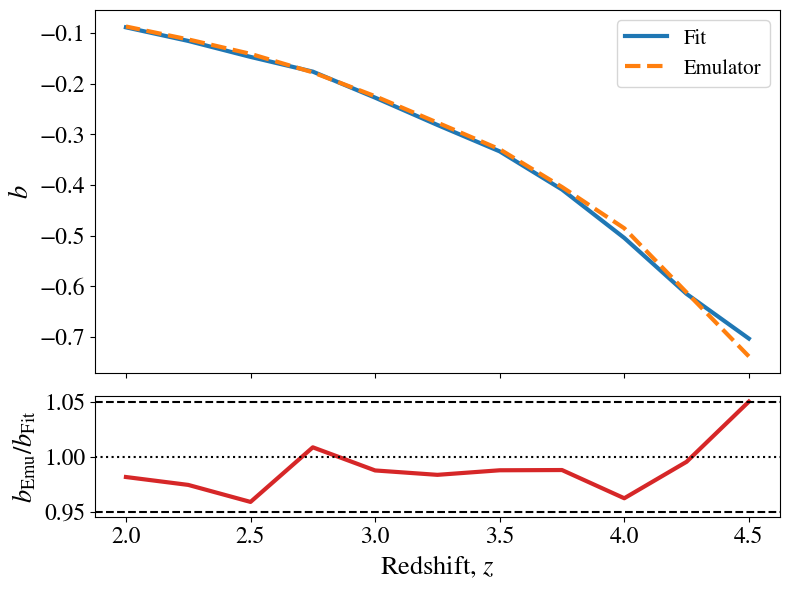

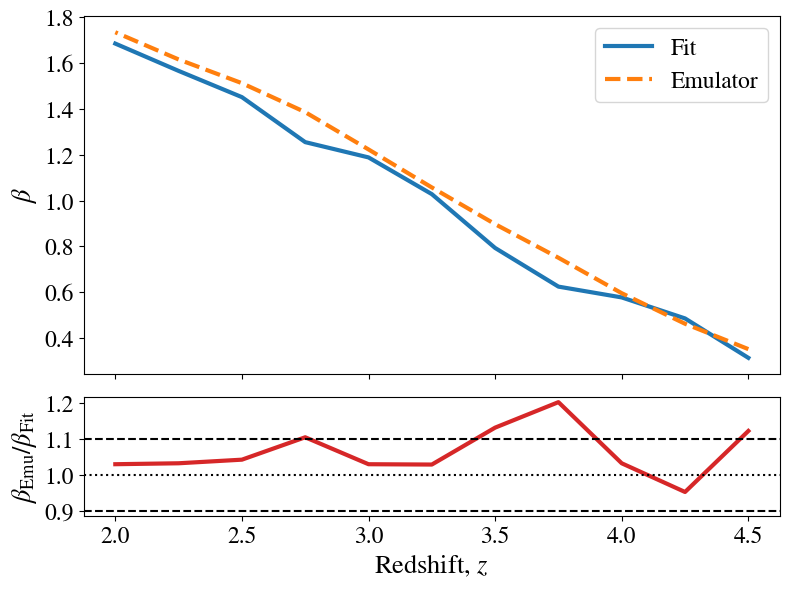

In [191]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

x = zz_arr
y1_top = -np.abs(fit_bias)
y2_top = pred_bias
y1_bottom = fit_beta
y2_bottom = pred_beta

lwu = 3
# Top panel
ax1 = plt.subplot(gs[0])
ax1.plot(x, y1_top, '-', label='Fit', lw=lwu)
ax1.plot(x, y2_top, '--', label='Emulator', lw=lwu)
ylab = r'$b$'
plot_template(ax1, ylabel=ylab, legend=0)
plt.setp(ax1.get_xticklabels(), visible=False)

# Subpanel for relative difference in top panel
ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.plot(x, y2_top/y1_top, 'C3', lw=lwu)
ax2.axhline(1, ls=':', color='k')
ax2.axhline(1.05, ls='--', color='k')
ax2.axhline(0.95, ls='--', color='k')

ylab = r'$b_\mathrm{Emu}/b_\mathrm{Fit}$'
xlab = r'Redshift, $z$'
plot_template(ax2, xlabel=xlab, ylabel=ylab, legend=1, ftsize_legend=17)

plt.tight_layout()
plt.savefig('central_bias.png')

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# Bottom panel
ax3 = plt.subplot(gs[0])
ax3.plot(x, y1_bottom, '-', label='Fit', lw=lwu)
ax3.plot(x, y2_bottom, '--', label='Emulator', lw=lwu)
ylab = r'$\beta$'
plot_template(ax3, ylabel=ylab, legend=0, ftsize_legend=17)
plt.setp(ax3.get_xticklabels(), visible=False)

# Subpanel for relative difference in bottom panel
ax4 = plt.subplot(gs[1], sharex=ax3)
ax4.plot(x, y2_bottom/y1_bottom, 'C3', lw=lwu)
ax4.axhline(1, ls=':', color='k')
ax4.axhline(1.1, ls='--', color='k')
ax4.axhline(0.9, ls='--', color='k')

ylab = r'$\beta_\mathrm{Emu}/\beta_\mathrm{Fit}$'
xlab = r'Redshift, $z$'
plot_template(ax4, xlabel=xlab, ylabel=ylab, legend=1)

plt.tight_layout()
plt.savefig('central_beta.png')

In [20]:
sim_suite='central'
folder = path_program + "data/"

folder_chains = "/data/desi/scratch/jchavesm/p3d_fits_new/"

folder_interp = path_program + "data/plin_interp/"
folder_lya_data = path_program + "data/best_arinyo/"

if sim_suite == "hypercube":
    err_p1d = np.load(folder + "p1d_4_fit.npz")
    err_p3d = np.load(folder + "p3d_4_fit.npz")
else:
    err_p1d = np.load(folder + "p1d_4_fit_extended.npz")
    err_p3d = np.load(folder + "p3d_4_fit_extended.npz")

kmax_3d = 5
noise_3d = 0.075
kmax_1d = 5
noise_1d = 0.01

## TEST ARCHIVE

In [15]:
folder_chains = (
        "/home/jchaves/Proyectos/projects/lya/data/pkfits/p3d_fits_new/"
    )

In [16]:
sim_suite = 'mpg_central'

In [155]:
best_predicted_Arinyo, p3d = p3d_emu._get_p3D_Mpc(archive_test, data_emu)

NameError: name 'archive_test' is not defined

In [78]:
best_predicted_Arinyo.shape

(11, 8)

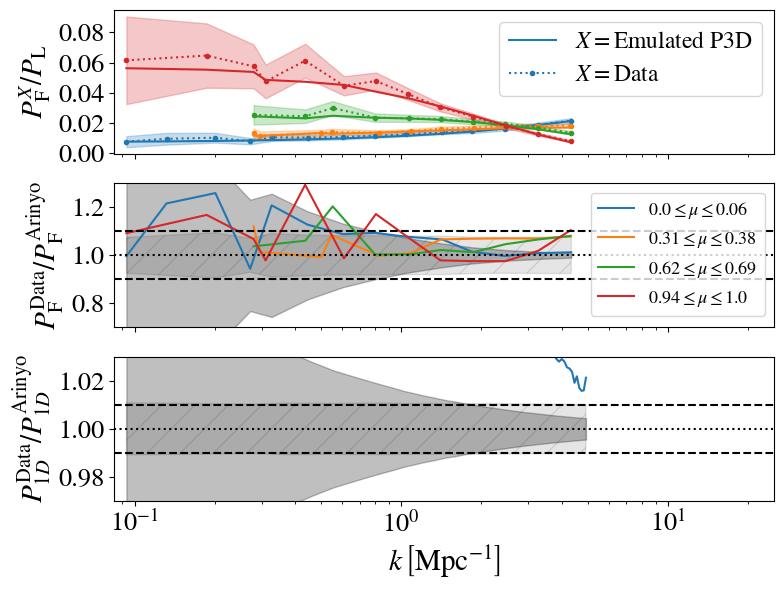

In [130]:
ind_book = 10
pars = params_numpy2dict(best_predicted_Arinyo[ind_book])
data_emu["model"][ind_book].plot_fits(pars, plot_emu=True)

In [139]:
ind_book = 0
pars = params_numpy2dict(data_emu["model"][ind_book].data['emu_params'])
pars

{'bias': 0.18662702856130953,
 'beta': -2.300054388536311,
 'd1_q1': 0.21501431598191986,
 'd1_kvav': 0.09836390937911825,
 'd1_av': 1.4333671132654395,
 'd1_bv': 14.738186021221429}

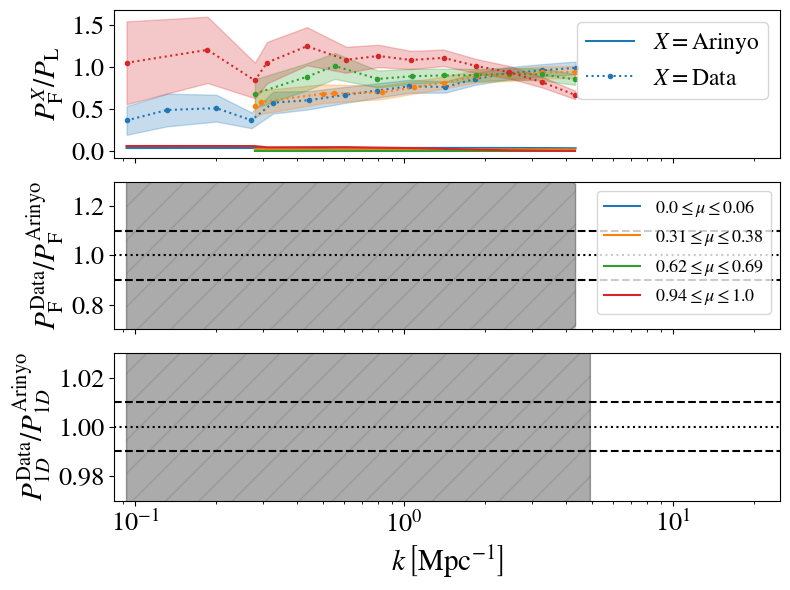

In [140]:

data_emu["model"][ind_book].plot_fits(pars)

4.5

In [108]:
def get_diff(model_all, best_params, ind_book, flag='one'):

    model = model_all[0]
    mask3d = model.ind_fit3d[:,0]
    mask1d = model.ind_fit1d
    k3d = np.nanmedian(model.data["k3d"][mask3d], axis=1)
    k1d = model.data["k1d"][mask1d]
    
    if(flag == 'one'):
        model = model_all[ind_book]
        
        pars = params_numpy2dict(best_params[ind_book])
        
        p3d_best = model.get_model_3d(parameters=pars)[mask3d, :]
        p1d_best = model.get_model_1d(parameters=pars)[mask1d]
        p3d_data = model.data["p3d"][mask3d, :]
        p1d_data = model.data["p1d"][mask1d]
        
        rdiff = 1 - p3d_best/p3d_data
        bias3d = np.nanmedian(rdiff, axis=1)
        err3d = np.nanstd(rdiff, axis=1)        

        bias1d = 1 - p1d_best/p1d_data
    elif(flag == 'all'):
        nsim = len(model_all)
        bias3d = np.zeros((nsim, k3d.shape[0]))
        err3d = np.zeros((nsim, k3d.shape[0]))
        bias3d = np.zeros((nsim, k3d.shape[0]))
        bias1d = np.zeros((nsim, k1d.shape[0]))
        for ii_sim in range(nsim):
            pars = params_numpy2dict(best_params[ii_sim])
            model = model_all[ii_sim]
        
            p3d_best = model.get_model_3d(parameters=pars)[mask3d, :]
            p1d_best = model.get_model_1d(parameters=pars)[mask1d]
            p3d_data = model.data["p3d"][mask3d, :]
            p1d_data = model.data["p1d"][mask1d]

            rdiff = 1 - p3d_best/p3d_data
            bias3d[ii_sim] = np.nanmedian(rdiff, axis=1)
            err3d[ii_sim] = np.nanstd(rdiff, axis=1)        

            bias1d[ii_sim] = 1 - p1d_best/p1d_data
        
    return k3d, bias3d, err3d, k1d, bias1d

In [98]:
ind_book = 5
_ = get_diff(data_emu["model"], best_predicted_Arinyo, ind_book, flag='one')
k3d, bias3d, err3d, k1d, bias1d = _

In [109]:

_ = get_diff(data_emu["model"], best_predicted_Arinyo, ind_book, flag='all')
k3d, bias3d, err3d, k1d, bias1d = _

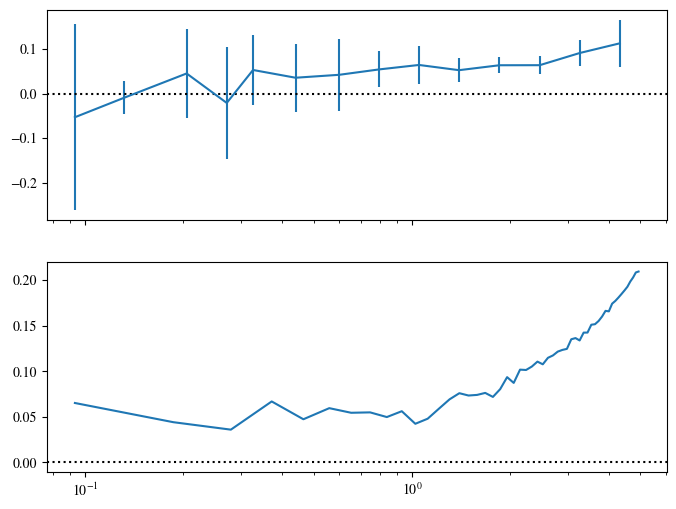

In [100]:
fig, ax = plt.subplots( 2, sharex=True, figsize=(8, 6))

ax[0].errorbar(k3d, bias3d, err3d)
ax[1].plot(k1d, bias1d)

for ii_ax in range(2):
    ax[ii_ax].axhline(color='k', ls=":")
    ax[ii_ax].set_xscale('log')


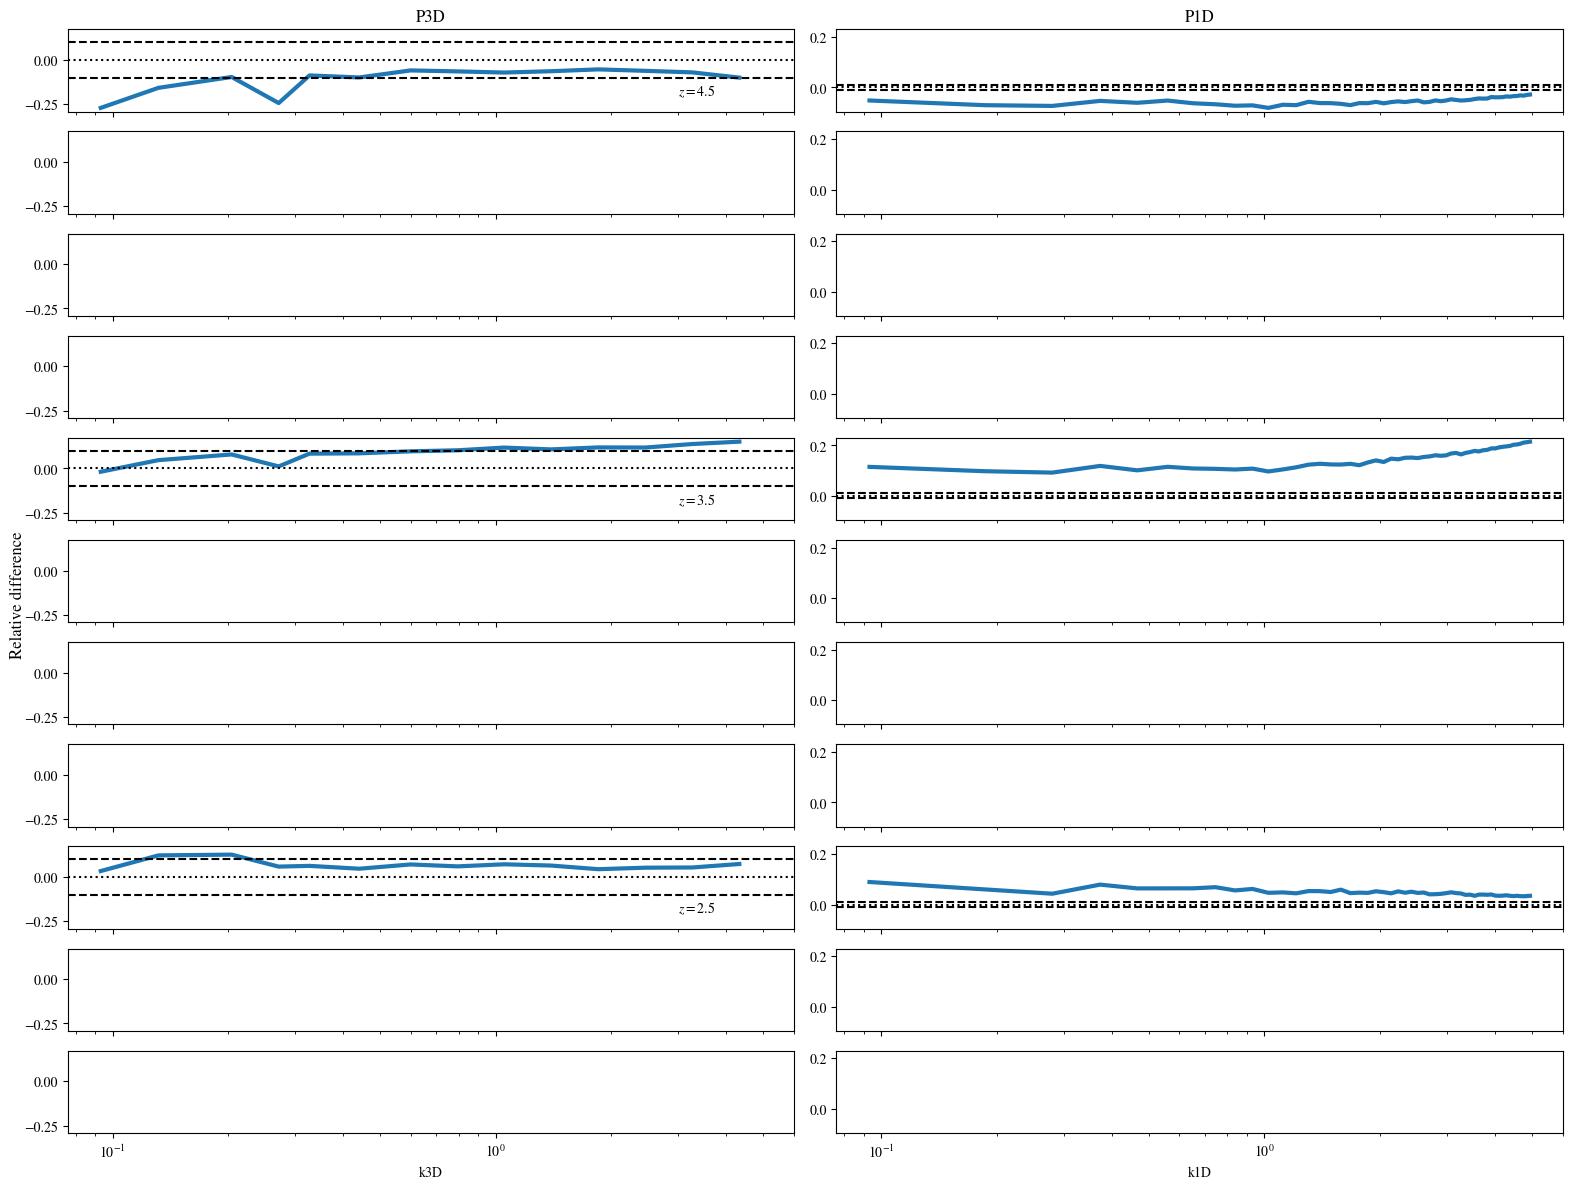

In [141]:
fig, ax = plt.subplots(bias3d.shape[0], 2, sharex=True, sharey='col', figsize=(16, 12))

for ii_ax in range(0, bias3d.shape[0], 4):
#     ax[ii_ax, 0].errorbar(k3d, bias3d[ii_ax], err3d[ii_ax])
    ax[ii_ax, 0].plot(k3d, bias3d[ii_ax], lw=3)
    ax[ii_ax, 1].plot(k1d, bias1d[ii_ax], lw=3)

    zflag = data_emu["model"][ii_ax].data['z'][0]
    ax[ii_ax, 0].axhline(-0.1, color='k', ls="--")
    ax[ii_ax, 0].axhline(0.1, color='k', ls="--")
    ax[ii_ax, 1].axhline(-0.01, color='k', ls="--")
    ax[ii_ax, 1].axhline(0.01, color='k', ls="--")
    ax[ii_ax, 0].text(3, -0.2, r'$z=$'+str(zflag))
    for jj_ax in range(2):
        ax[ii_ax, jj_ax].axhline(color='k', ls=":")
        ax[ii_ax, jj_ax].set_xscale('log')

ax[0, 0].set_title('P3D')
ax[0, 1].set_title('P1D')
ax[-1, 0].set_xlabel('k3D')
ax[-1, 1].set_xlabel('k1D')
fig.supylabel('Relative difference')
plt.tight_layout()
# plt.savefig('test_central.pdf')